In [8]:
from shapely.geometry import  LineString, mapping
import matplotlib.pyplot as plt
from gerrychain import Graph
import geopandas as gpd
import networkx as nx
import warnings
from copy import deepcopy
warnings.filterwarnings('ignore')

In [2]:
%%time
# md_mggg = gpd.read_file("https://github.com/mggg-states/MD-shapefiles/blob/master/MD_precincts_abs.zip?raw=true")
# md_full = gpd.read_file("shapes/MD_precincts_full/")
gdf = gpd.read_file("shapes/MD_vtd/")
graph = Graph.from_file("shapes/MD_vtd")

VAP_COLS = list(filter(lambda x: "VAP" in x, gdf.columns))

CPU times: user 22.6 s, sys: 852 ms, total: 23.5 s
Wall time: 23.6 s


In [227]:
def edges_geoms(graph, shp, key = "GEOID20"):
    key_dict = {}
    for _idx, row in shp.iterrows():
        key_dict[row[key]] = row['geometry']
    edges = list(graph.edges)
    nodes = [((graph.nodes[u]), (graph.nodes[v])) for u,v in edges]
    keys = [(n1[key], n2[key]) for n1, n2 in nodes]
    geoms = [(key_dict[k1], key_dict[k2]) for k1,k2 in keys]
    return geoms

def edges_to_gdf(graph, shp, key = "GEOID20"):
    dual = gpd.GeoDataFrame(gpd.GeoSeries([LineString([poly1.centroid, poly2.centroid]) for poly1,poly2 in edges_geoms(graph, shp, key = key)]), columns = ['geometry'])
    return dual.set_crs(shp.crs)

def find_node_by_key(keyval, graph, key = "GEOID20",):
    for node in graph:
        if graph.nodes[node][key] == keyval:
            return node
    return -1

def plot_problems(graph, shp, key = "GEOID20"):
    components = list(nx.connected_components(graph))
    print([len(c) for c in components])
    biggest_component_size = max(len(c) for c in components)
    problem_components = [c for c in components if len(c) != biggest_component_size]
    problem_nodes = [node for component in problem_components for node in component]
    problem_geoids = [graph.nodes[node][key] for node in problem_nodes]
    
    is_a_problem = shp[key].isin(problem_geoids)
    shp.plot(column=is_a_problem, figsize=(10, 10))
    plt.axis('off')
    plt.show()
    return problem_geoids

def plot_lines(graph, gdf):
    fig, ax = plt.subplots(figsize=(20,12))

    gdf.plot(ax=ax,
            )
    edges_to_gdf(graph, gdf).plot(ax=ax,
                                  color='black',
                                 )
    _ = plt.axis('off')
    return

def filter_out_bad_edges(graph, original_edges, this_geoid, good_geoids):
    this_node = find_node_by_key(this_geoid, graph)
    good_nodes = [find_node_by_key(good_geoid, graph) for good_geoid in good_geoids]
    edges_from_this_node = list(filter(lambda x: this_node in x, original_edges))
    edges_to_remove = []
    for (x,y) in edges_from_this_node:
        if x not in good_nodes and y not in good_nodes:
            edges_to_remove.append((x,y))
    return edges_to_remove

In [279]:
find_node_by_key("24039ZZZZZZ", graph)

1497

In [284]:
find_node_by_key("2400514-006", graph)

208

In [283]:
gdf[gdf["GEOID20"] == "24039ZZZZZZ"]["GEOID20"]

1497    24039ZZZZZZ
Name: GEOID20, dtype: object

In [367]:
ids_to_good_connects_leg = {
    "24017ZZZZZZ": ["2401703-001"],
    "24037ZZZZZZ": ["2403701-002"],
    "24039ZZZZZZ": ["2403910-001", "2403910-002", "2403912-001"],
    "2401910-001": ["2401918-001"],
    "2401906-001": ["2401905-001", "2401904-001"],
    "24009ZZZZZZ": ["2400901-006"],
    "2401904-001": ["2401906-001", "2401905-001", "2401909-001", "2401916-001"],
    "2401908-001": ["2401907-003"],
    "2401907-003": ["2401908-001", "2401916-001", "2401909-001", "2401913-001", "2401907-010", "2401907-004", "2401907-002", "2401907-006"],
    "24041ZZZZZZ": ["2404105-001"],
    "2403504-006": ["2403504-003"],
    "2403504-003": ["2403504-006", "2403504-001", "2403504-002"],
    "2403504-002": ["2403504-003", "2403504-001", "2403505-002"],
    "2403504-001": ["2403504-003", "2403504-002"],
    "2402905-001": ["2402907-001", "2402906-001"],
    "2402906-001": ["2402905-001", "2402907-001", "2402904-002", "2402903-001"],
    "2402903-001": ["2402906-001", "2402904-002", "2402904-001", "2402902-001", "2402903-002"],
    "2402903-002": ["2402903-001", "2402902-001"],
    "24015ZZZZZZ": ["2401505-003"],
}

edges_to_add_leg = [
    ("2401502-001", "2401502-002"),
    ("2403709-001", "2403702-001"),
    ("2401709-002", "2400902-002"), # Benedict bridge
]

ids_to_good_connects_cong = {
    "24017ZZZZZZ": ["2401703-001"],
    "24037ZZZZZZ": ["2403701-002", "24039ZZZZZZ", "2401910-001", "2401906-001"], # added three across water
    "24039ZZZZZZ": ["2403910-001", "2403910-002", "2403912-001"],
    "2401910-001": ["2401918-001"],
    "2401906-001": ["2401905-001", "2401904-001"],
    "24009ZZZZZZ": ["2400901-006", "2401906-001", "2401904-001", "2401908-001"], # added three across water
    "2401904-001": ["2401906-001", "2401905-001", "2401909-001", "2401916-001"],
    "2401908-001": ["2401907-003"],
    "2401907-003": ["2401908-001", "2401916-001", "2401909-001", "2401913-001", "2401907-010", "2401907-004", "2401907-002", "2401907-006"],
    "24041ZZZZZZ": ["2404105-001"],
    "2403504-006": ["2403504-003"],
    "2403504-003": ["2403504-006", "2403504-001", "2403504-002", "2400305-001", "2400305-002"], # added two crossing bridge
    "2403504-002": ["2403504-003", "2403504-001", "2403505-002"],
    "2403504-001": ["2403504-003", "2403504-002", "2400305-001", "2400305-002"], # added two crossing bridge
    "2402905-001": ["2402907-001", "2402906-001"],
    "2402906-001": ["2402905-001", "2402907-001", "2402904-002", "2402903-001"],
    "2402903-001": ["2402906-001", "2402904-002", "2402904-001", "2402902-001", "2402903-002"],
    "2402903-002": ["2402903-001", "2402902-001"],
    "24015ZZZZZZ": ["2401505-003"],
}

edges_to_add_cong = [
    ("2401502-001", "2401502-002"),
    ("2403709-001", "2403702-001"),
    ("2401709-002", "2400902-002"), # Benedict bridge
    ("24037ZZZZZZ", "24039ZZZZZZ"),
    ("24037ZZZZZZ", "2401910-001"),
    ("24037ZZZZZZ", "2401906-001"),
    ("24009ZZZZZZ", "2401906-001"),
    ("24009ZZZZZZ", "2401904-001"),
    ("24009ZZZZZZ", "2401908-001"),
    ("2403504-003", "2400305-001"),
    ("2403504-003", "2400305-002"),
    ("2403504-001", "2400305-001"),
    ("2403504-001", "2402903-001"),   
]

In [368]:
graph_leg = deepcopy(graph)
graph_cong = deepcopy(graph)

edges_for_removal_leg = []
for geoid, good_geoids in ids_to_good_connects_leg.items():
    edges_for_removal_leg += (filter_out_bad_edges(graph, list(graph.edges), geoid, good_geoids))
    
edges_for_removal_cong = []
for geoid, good_geoids in ids_to_good_connects_cong.items():
    edges_for_removal_cong += (filter_out_bad_edges(graph, list(graph.edges), geoid, good_geoids))
    
graph_leg.remove_edges_from(edges_for_removal_leg)
graph_leg.add_edges_from([(find_node_by_key(x, graph), find_node_by_key(y, graph)) for (x,y) in edges_to_add_leg])

graph_cong.remove_edges_from(edges_for_removal_cong)
graph_cong.add_edges_from([(find_node_by_key(x, graph), find_node_by_key(y, graph)) for (x,y) in edges_to_add_cong])

print(len(graph.edges))
print(len(graph_leg.edges))
print(len(graph_cong.edges))

5653
5498
5509


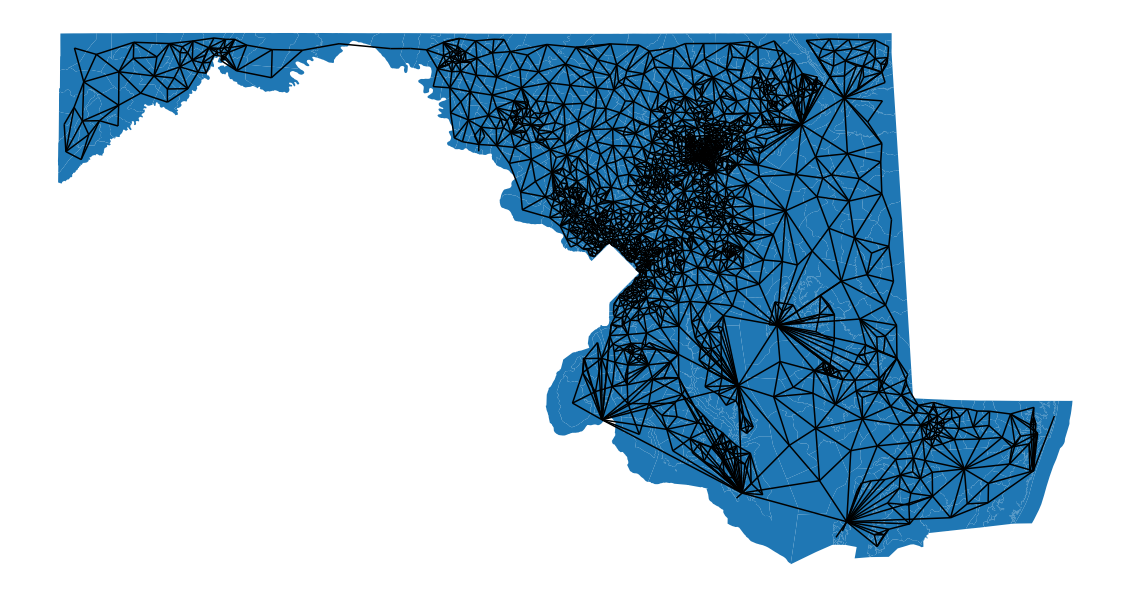

In [369]:
plot_lines(graph, gdf)
plt.savefig("plots/MD_all_connected.png", bbox_inches='tight')

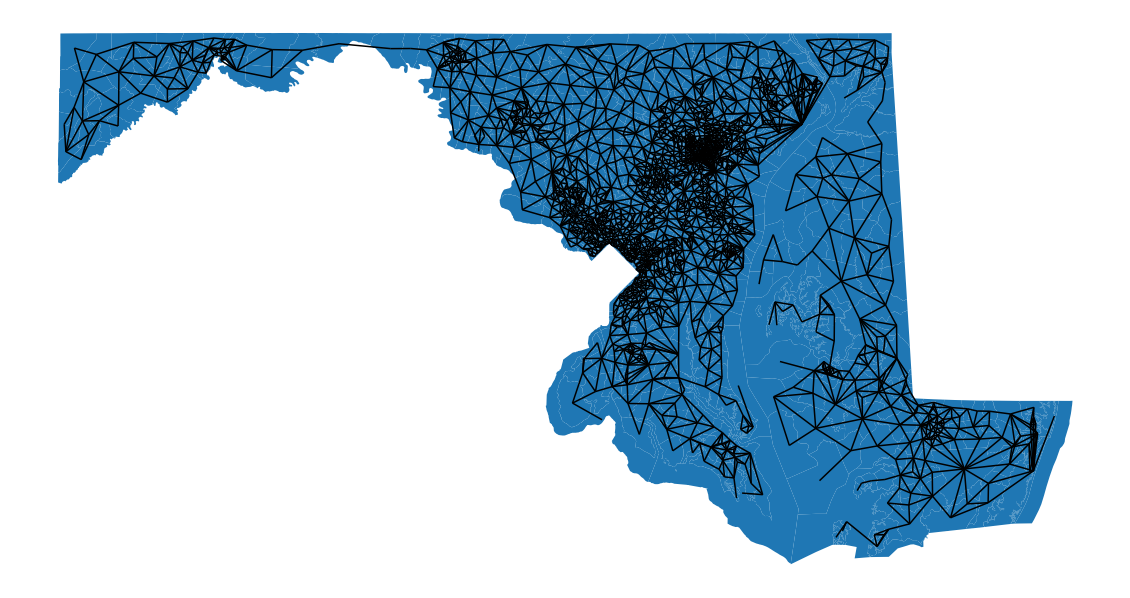

In [370]:
plot_lines(graph_leg, gdf)
plt.savefig("plots/MD_leg.png", bbox_inches='tight')

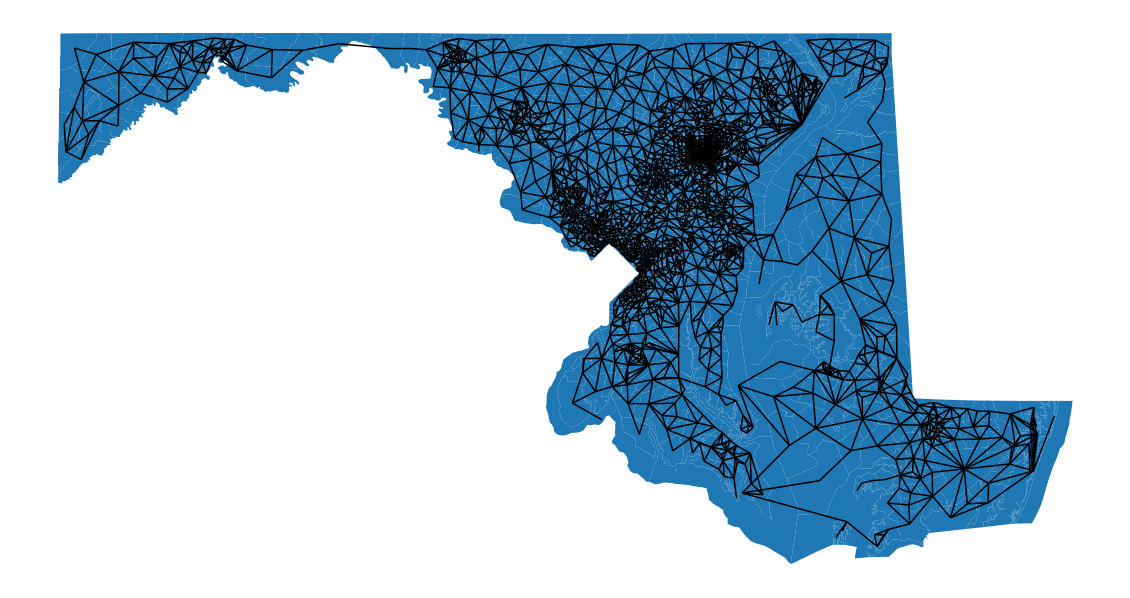

In [371]:
plot_lines(graph_cong, gdf)
plt.savefig("plots/MD_cong.png", bbox_inches='tight')

[2042]


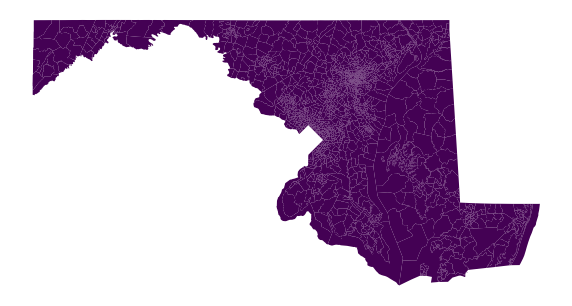

[]

In [372]:
plot_problems(graph_leg, gdf)

[2042]


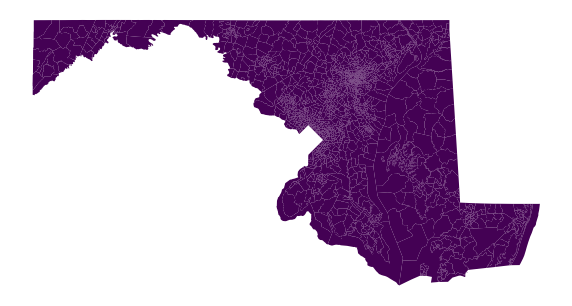

[]

In [373]:
plot_problems(graph_cong, gdf)

In [374]:
graph_leg.to_json("../One-Click-Chains/jsons/MD_leg.json")

In [375]:
graph_cong.to_json("../One-Click-Chains/jsons/MD_cong.json")